# Applying Graph Theory to Algorithmic Trading

Showing off visibility graphs for an algorithmic trading application. We compute visibility graphs of the price in a rolling window then compute network science metrics on the resulting graph to get an interesting indicator.

* Tutorial: [Applying Graph Theory to Algorithmic Trading | Time Series Visibility Graphs](https://www.youtube.com/watch?v=bA1I4Upzxgc)
* Full Code: https://github.com/neurotrader888/TimeSeriesVisibilityGraphs

Links

- https://en.wikipedia.org/wiki/Visibility_graph
- https://en.wikipedia.org/wiki/Network_science
- https://networkx.org/
- https://github.com/CarlosBergillos/ts2vg

In [1]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
from tqdm import tqdm

### Time Series to Visibility Graph

In [2]:
def ts_to_vg(data: np.array, times: np.array = None, horizontal: bool = False):
    # Convert timeseries to visibility graph with DC algorithm

    if times is None:
        times = np.arange(len(data))

    network_matrix = np.zeros((len(data), len(data)))

    # DC visablity graph func
    def dc_vg(x, t, left, right, network):
        if left >= right:
            return
        k = np.argmax(x[left:right+1]) + left # Max node in left-right
        #print(left, right, k)
        for i in range(left, right+1):
            if i == k:
                continue

            visible = True
            for j in range(min(i+1, k+1), max(i, k)):
                # Visiblity check, EQ 1 from paper 
                if horizontal:
                    if x[j] >= x[i]:
                        visible = False
                        break
                else:
                    if x[j] >= x[i] + (x[k] - x[i]) * ((t[j] - t[i]) / (t[k] - t[i])):
                        visible = False
                        break

            if visible:
                network[k, i] = 1.0
                network[i, k] = 1.0
        
        dc_vg(x, t, left, k - 1, network) 
        dc_vg(x, t, k + 1, right, network) 

    dc_vg(data, times, 0, len(data) - 1, network_matrix)
    return network_matrix

def plot_ts_visibility(network: np.array, data: np.array, times: np.array = None, horizontal: bool = False):
    # Plotting function for visibility graph
    if times is None:
        times = np.arange(len(data))

    plt.style.use('dark_background') 
    fig, axs = plt.subplots(2, 1, sharex=True)
    # Plot connections and series
    for i in range(len(data)):
        for j in range(i, len(data)):
            if network[i, j] == 1.0:
                if horizontal:
                    axs[0].plot([times[i], times[j]], [data[i], data[i]], color='red', alpha=0.8)
                    axs[0].plot([times[i], times[j]], [data[j], data[j]], color='red', alpha=0.8)
                else:
                    axs[0].plot([times[i], times[j]], [data[i], data[j]], color='red', alpha=0.8)
    axs[0].plot(times, data)
    #axs[0].bar(times, data, width=0.1)
    axs[0].get_xaxis().set_ticks(list(times))

    # Plot graph
    for i in range(len(data)):
        axs[1].plot(times[i], 0, marker='o', color='orange')

    for i in range(len(data)):
        for j in range(i, len(data)):
            if network[i, j] == 1.0:
                Path = mpath.Path
                mid_time = (times[j] + times[i]) / 2.
                diff = abs(times[j] - times[i])
                pp1 = mpatches.PathPatch(Path([(times[i], 0), (mid_time, diff), (times[j], 0)],[Path.MOVETO, Path.CURVE3, Path.CURVE3]), fc="none", transform=axs[1].transData, alpha=0.5)
                axs[1].add_patch(pp1)
    axs[1].get_yaxis().set_ticks([])
    axs[1].get_xaxis().set_ticks(list(times))
    plt.show()

    0 1 2 3 4 5 6 7 8 9
    -------------------
0 | 0 1 0 0 0 0 0 0 0 0
1 | 1 0 1 1 0 0 0 0 0 0
2 | 0 1 0 1 0 0 0 0 0 0
3 | 0 1 1 0 1 1 0 1 0 0
4 | 0 0 0 1 0 1 0 0 0 0
5 | 0 0 0 1 1 0 1 1 0 0
6 | 0 0 0 0 0 1 0 1 0 0
7 | 0 0 0 1 0 1 1 0 1 1
8 | 0 0 0 0 0 0 0 1 0 1
9 | 0 0 0 0 0 0 0 1 1 0


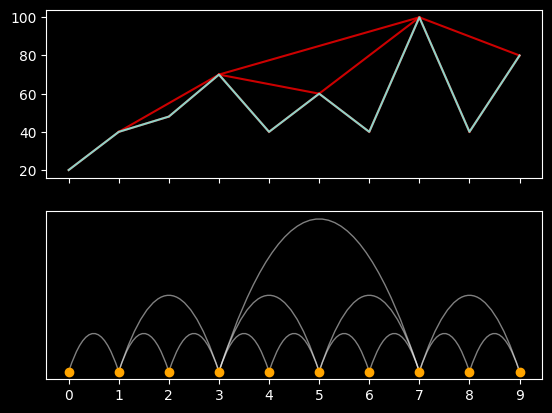

In [3]:
# Example data from video
dat = np.array([20, 40, 48, 70, 40, 60, 40, 100, 40, 80])
#dat = np.array([.71, .53, .56, .29, .30, .77, .01, .76, .81, .71, .05, .41, .86, .79, .37, .96, .87, .06, .95, .36])

# Cosine wave with 4 cycles (period = 12)
#dat = np.cos( 2 * np.pi * (1/12) * np.arange(48) )

# Daily bitcoin data, 
#bitcoin_data = pd.read_csv('src/BTCUSDT86400.csv')
# Decemeber 2022
#dat = bitcoin_data['close'].iloc[-31:].to_numpy()
    
# Network is the adjacency matrix
network = ts_to_vg(dat)
  
# Print adjacency matrix
network = network.astype(int)
index = list(range(len(dat)))
index = [str(x) for x in index] 
print("    " + " ".join(index))
print("    " + "-" * (len(dat) * 2 - 1))
for i in range(len(dat)):
    row = f"{i} | {str(network[:, i])[1:-1]}"
    print(row)

plot_ts_visibility(network, dat, horizontal=False)

### `ts2vg` Conversion Example

In [4]:
# pip install ts2vg
from ts2vg import HorizontalVG, NaturalVG

[[0 1 0 0 0 0 0 0 0 0]
 [1 0 1 1 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 0]
 [0 1 1 0 1 1 0 1 0 0]
 [0 0 0 1 0 1 0 0 0 0]
 [0 0 0 1 1 0 1 1 0 0]
 [0 0 0 0 0 1 0 1 0 0]
 [0 0 0 1 0 1 1 0 1 1]
 [0 0 0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 1 1 0]]


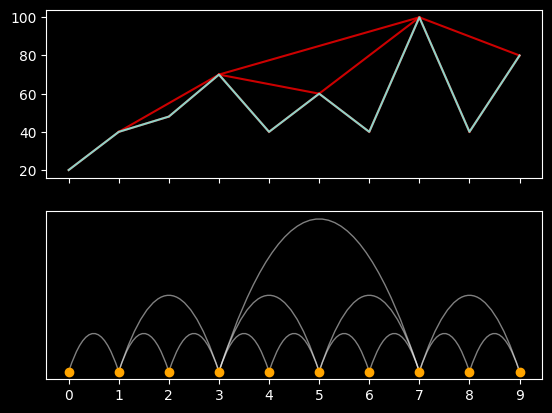

In [5]:
dat = np.array([20, 40, 48, 70, 40, 60, 40, 100, 40, 80])
ng = NaturalVG()
ng.build(dat)

adj_matrix = ng.adjacency_matrix()
print(adj_matrix)

plot_ts_visibility(adj_matrix, dat)


#hg = HorizontalVG()
#hg.build(dat)
#plot_ts_visibility(hg.adjacency_matrix(), dat, horizontal=True)

### Average Shortest Path

In [6]:
import networkx as nx

In [7]:
def shortest_path_length(close: np.array, lookback: int):

    avg_short_dist_p = np.zeros(len(close))
    avg_short_dist_n = np.zeros(len(close))

    avg_short_dist_p[:] = np.nan
    avg_short_dist_n[:] = np.nan

    for i in range(lookback, len(close)):
        dat = close[i - lookback + 1: i+1]

        pos = NaturalVG()
        pos.build(dat)

        neg = NaturalVG()
        neg.build(-dat)

        neg = neg.as_networkx()
        pos = pos.as_networkx()
    
        # you could replace shortest_path_length with other networkx metrics..
        avg_short_dist_p[i] = nx.average_shortest_path_length(pos)
        avg_short_dist_n[i] = nx.average_shortest_path_length(neg)
        
        # Another possibility...
        #nx.degree_assortativity_coefficient(pos)
        #nx.degree_assortativity_coefficient(neg)
        # All kinds of stuff here
        # https://networkx.org/documentation/stable/reference/algorithms/index.html 
    return avg_short_dist_p, avg_short_dist_n

In [8]:
# Load data
data = pd.read_csv('src/BTCUSDT3600.csv')
data['date'] = data['date'].astype('datetime64[s]')
data = data.set_index('date')

In [9]:
lookback = 12
close_arr = data['close'].to_numpy()
pos, neg = shortest_path_length(close_arr, lookback)
data['pos'] = pos
data['neg'] = neg

data = data.dropna().reset_index()

# Plot visibility graph with max and min avearge_shortest_path
max_idx = data['pos'].idxmax()
min_idx = data['pos'].idxmin()

max_dat = data.iloc[max_idx - lookback +1: max_idx+1]['close'].to_numpy()
min_dat = data.iloc[min_idx - lookback +1: min_idx+1]['close'].to_numpy()

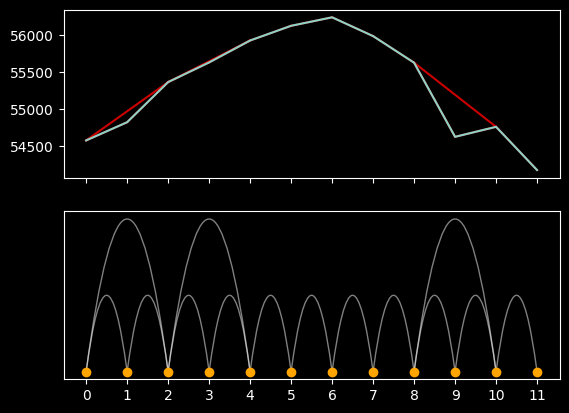

In [10]:
g = NaturalVG()
g.build(max_dat)
plot_ts_visibility(g.adjacency_matrix(), max_dat)

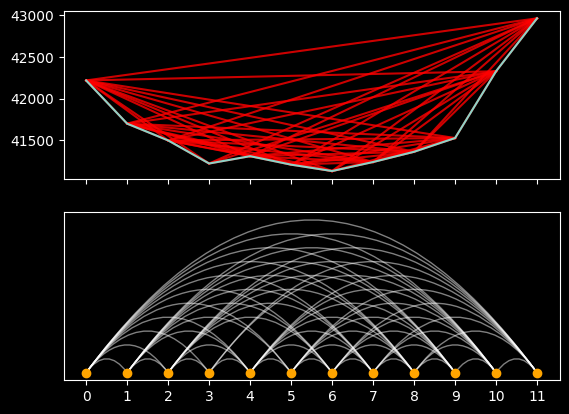

In [11]:
g = NaturalVG()
g.build(min_dat)
plot_ts_visibility(g.adjacency_matrix(), min_dat)

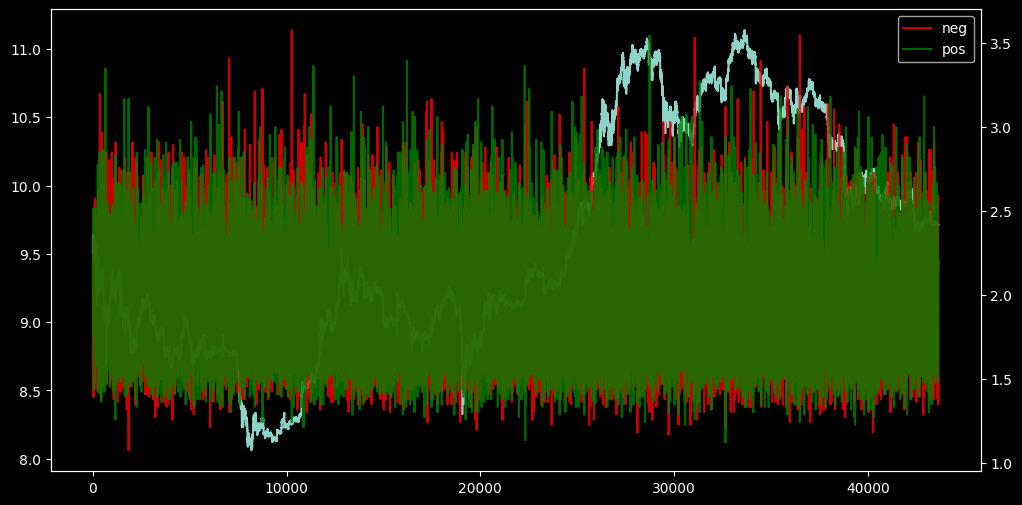

In [12]:
np.log(data['close']).plot(figsize=(12, 6))
plt.twinx()
data['neg'].plot(color='red', label='neg', alpha=0.8)
data['pos'].plot(color='green',label='pos', alpha=0.8)
plt.legend()
plt.show()

### Visibility Graph Results

In [13]:
# Load data
data = pd.read_csv('src/BTCUSDT3600.csv')
data['date'] = data['date'].astype('datetime64[s]')
data = data.set_index('date')

In [14]:
# Next log return
data['r'] = np.log(data['close']).diff().shift(-1)

# Compute shortest average path length for last 12 vals
pos, neg = shortest_path_length(data['close'].to_numpy(), 12)
data['pos'] = pos
data['neg'] = neg

# Compute signals
data['long_sig'] = 0
data['short_sig'] = 0
data.loc[data['pos'] > data['neg'], 'long_sig'] = 1
data.loc[data['pos'] < data['neg'], 'short_sig'] = -1
data['combined_sig'] = data['long_sig'] + data['short_sig']

# Compute returns 
data['long_ret'] = data['long_sig'] * data['r']
data['short_ret'] = data['short_sig'] * data['r']
data['comb_ret'] = data['combined_sig'] * data['r']

# Compute profit factor
long_pf = data[data['long_ret'] > 0]['long_ret'].sum() / data[data['long_ret'] < 0]['long_ret'].abs().sum()
short_pf = data[data['short_ret'] > 0]['short_ret'].sum() / data[data['short_ret'] < 0]['short_ret'].abs().sum()
combined_pf = data[data['comb_ret'] > 0]['comb_ret'].sum() / data[data['comb_ret'] < 0]['comb_ret'].abs().sum()
    
print("Long PF", long_pf)
print("Short PF", short_pf)
print("Combined PF", combined_pf)

Long PF 1.0526824000968118
Short PF 1.0485057527134967
Combined PF 1.0507160184338582


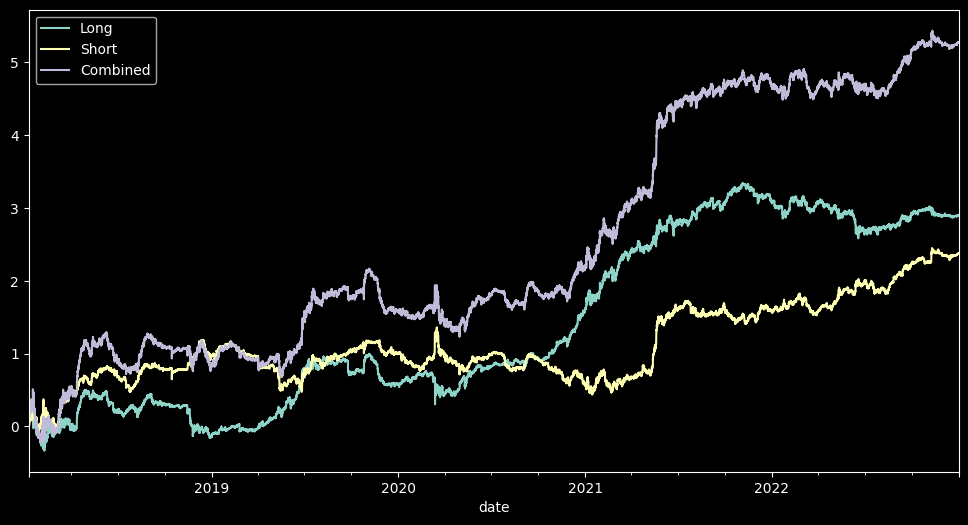

In [15]:
# Plot cumulative log return
plt.style.use('dark_background')
plt.figure(figsize=(12, 6))
data['long_ret'].cumsum().plot(label='Long')
data['short_ret'].cumsum().plot(label='Short')
data['comb_ret'].cumsum().plot(label='Combined')
plt.legend()
plt.show()

In [16]:
# heatmap stuff
heatmap_df = pd.DataFrame()

for lb in tqdm(range(6, 25)):
    #print(lb)
    # Compute shortest average path length for last 12 vals
    pos, neg = shortest_path_length(data['close'].to_numpy(), lb)
    data['pos'] = pos
    data['neg'] = neg

    # Compute signals
    data['long_sig'] = 0
    data['short_sig'] = 0
    data.loc[data['pos'] > data['neg'], 'long_sig'] = 1
    data.loc[data['pos'] < data['neg'], 'short_sig'] = -1
    data['combined_sig'] = data['long_sig'] + data['short_sig']

    # Compute returns 
    data['long_ret'] = data['long_sig'] * data['r']
    data['short_ret'] = data['short_sig'] * data['r']
    data['comb_ret'] = data['combined_sig'] * data['r']

    # Compute profit factor
    long_pf = data[data['long_ret'] > 0]['long_ret'].sum() / data[data['long_ret'] < 0]['long_ret'].abs().sum()
    short_pf = data[data['short_ret'] > 0]['short_ret'].sum() / data[data['short_ret'] < 0]['short_ret'].abs().sum()
    combined_pf = data[data['comb_ret'] > 0]['comb_ret'].sum() / data[data['comb_ret'] < 0]['comb_ret'].abs().sum()

    heatmap_df.loc[lb, 'Long'] = long_pf
    heatmap_df.loc[lb, 'Short'] = short_pf
    heatmap_df.loc[lb, 'Combined'] = combined_pf

100%|███████████████████████████████████████████████████████████████████| 19/19 [03:03<00:00,  9.65s/it]


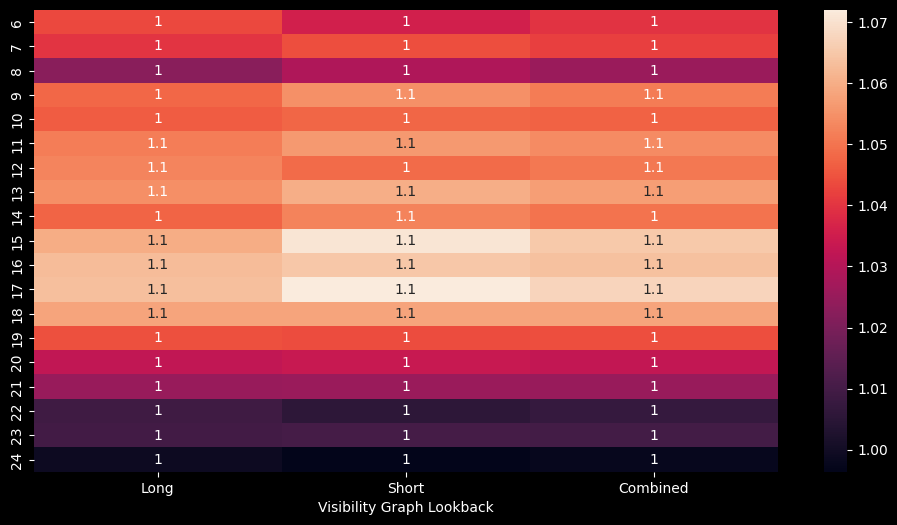

In [17]:
plt.style.use('dark_background')
plt.figure(figsize = (12, 6))
sns.heatmap(heatmap_df, annot=True)
plt.xlabel("Visibility Graph Lookback")
plt.show()

In [18]:
### Forecast

In [19]:
def network_prediction(network, data, times=None):
    '''
    May 21, 2023. This code will be covered in a future video.
    Implementation of this paper:

    Zhan, Tianxiang & Xiao, Fuyuan. (2021). 
    A novel weighted approach for time series forecasting based on visibility graph. 

    https://arxiv.org/abs/2103.13870
    '''
    if times is None:
        times = np.arange(len(data))

    n = len(data)
    degrees = np.sum(network, axis=1)
    num_edges = np.sum(network) # Number of edges * 2 (network is symmetric)

    # Transition probability matrix
    p = network.copy()
    for x in range(n):
        p[x, :] /= degrees[x]

    # Forecast vector
    forecasts = np.zeros(n -1)
    v = data[n-1]
    for x in range(n-1): # Forecast slope, not next val
        forecasts[x] = (v - data[x]) / (times[n-1] - times[x])

    srw = np.zeros(n-1)
    lrw_last = None
    walk_x = np.identity(n)
    t = 1
    while True:
        for x in range(n):
            walk_x[x,:] = np.dot(p.T, walk_x[x,:])
       
        # Find similarity with last node (most recent value)
        lrw = np.zeros(n-1) # -1 because not including last
        y = n - 1
        for x in range(n-1):
            lrw[x] =  (degrees[x] / num_edges) * walk_x[x, y]
            lrw[x] += (degrees[y] / num_edges) * walk_x[y, x]

        srw += lrw 
        if (lrw == lrw_last).all():
            #print(t)
            break
        lrw_last = lrw
        t += 1
        if t > 1000:
            break

    forecast_weights = srw / np.sum(srw)
    forecast = np.dot(forecast_weights, forecasts)

    return forecast